# Face Recognition -Model8

使用MTCNN進行人臉偵測

使用自建CNN模型進行人臉辨識

使用kaggle5位日本明星資料集

進行靜態圖像辨識

Transfer learning

In [1]:
from __future__ import division

# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

#Utilities相關函式庫
import os
import sys

# Python2.X和3.X相容
import six

# 圖像處理函示庫
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 數值處理函式庫
import pandas as pd
import numpy as np

# 機器學習函式庫
from sklearn.model_selection import train_test_split

# 深度學習函式庫
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Convolution2D, Dropout, Flatten, merge, Reshape, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, add, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import np_utils
from keras import regularizers
from keras import initializers
from keras.regularizers import l2
from keras import initializers
from keras.engine import Layer, InputSpec, get_source_inputs
from keras_vggface.vggface import VGGFace
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
import tensorflow as tf


# Backend
from keras import backend as K


# 相關參數設定
picture_size = 224
channel = 3
batch_size = 8  # 一次用多少筆資料更新模型
num_classes = 6  # 資料集有幾個類別
epochs = 300      # 訓練迭代次數
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model8_Transfer_VGGFace_V6, trained_model.h5' # 模型名稱


Using TensorFlow backend.


In [2]:
# 直接讀取處理好的檔案
total_img_resized = np.load('total_crop_resized_224.npy')
labelnames = np.load('labelnames.npy')
total_img_resized.shape

(521, 224, 224, 3)

In [22]:
# 切分訓練/測試資料
#train_x = total_img
#train_y = labelnames

train_x,test_x, train_y, test_y = train_test_split(total_img_resized,
                                                    labelnames,
                                                    test_size = 0.2,stratify= labelnames)#random_state = 123,
print('train:',train_x.shape,'test:',test_x.shape)

# 正規化資料
# 標準化0~255的值到0~1
# x_train_normalize = train_x.astype('float32') / 255.0
# x_test_normalize = test_x.astype('float32') / 255.0
x_train_normalize = preprocess_input(train_x)
x_test_normalize = preprocess_input(test_x)

train: (416, 224, 224, 3) test: (105, 224, 224, 3)


In [28]:
# Transfer learning-VGGFace+Resnet50
base_model = VGGFace(model='resnet50',include_top=False, input_shape=(picture_size, picture_size, channel))


# 凍結基底模型的權重，不更新
for layer in base_model.layers:
    layer.trainable = False

last_layer = base_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(4096)(x)




out = Dense(num_classes, activation='softmax', name='classifier')(x)
model = Model(base_model.input, out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_6[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [29]:
# 訓練模型
optimizer = Adam(lr=3e-6,decay=0.0001,beta_1=0.99,beta_2=0.999) #100e-6
# sgd = keras.optimizers.SGD(lr=1e-6, momentum=0.9, decay=1e-5, nesterov=True)
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [30]:
# Data Augmentation
datagen  = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True, 
            vertical_flip = False,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

In [31]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

# Fit model
aug_ratio = 2
steps_per_epoch = int(aug_ratio * train_x.shape[0] / batch_size)
validation_steps = int(aug_ratio * test_x.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(x_train_normalize, train_y, batch_size = batch_size),
                                   epochs = epochs,
                                   validation_data = (x_test_normalize, test_y),
                                   callbacks = [checkpoint, earlystop],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=validation_steps
                                   )

Epoch 1/300
104/104 [==============================] - 12s 120ms/step - loss: 1.4400 - acc: 0.5024 - val_loss: 0.6803 - val_acc: 0.7714

Epoch 00001: val_loss improved from inf to 0.68028, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model8_Transfer_VGGFace_V6, trained_model.h5
Epoch 2/300
104/104 [==============================] - 7s 63ms/step - loss: 0.6657 - acc: 0.7800 - val_loss: 0.3391 - val_acc: 0.8857

Epoch 00002: val_loss improved from 0.68028 to 0.33913, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model8_Transfer_VGGFace_V6, trained_model.h5
Epoch 3/300
104/104 [==============================] - 7s 65ms/step - loss: 0.4518 - acc: 0.8702 - val_loss: 0.2544 - val_acc: 0.9143

Epoch 00003: val_loss improved from 0.33913 to 0.25439, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model8_Transfer_VGGFace_V6, trained_model.h5
Epoch 4/300
104/104 [==============================] - 7s 65ms/ste

104/104 [==============================] - 7s 67ms/step - loss: 0.0791 - acc: 0.9736 - val_loss: 0.1331 - val_acc: 0.9619

Epoch 00036: val_loss did not improve from 0.12497
Epoch 37/300
104/104 [==============================] - 7s 67ms/step - loss: 0.0746 - acc: 0.9808 - val_loss: 0.1422 - val_acc: 0.9619

Epoch 00037: val_loss did not improve from 0.12497
Epoch 38/300
104/104 [==============================] - 7s 67ms/step - loss: 0.0910 - acc: 0.9760 - val_loss: 0.1508 - val_acc: 0.9524

Epoch 00038: val_loss did not improve from 0.12497
Epoch 39/300
104/104 [==============================] - 7s 66ms/step - loss: 0.1055 - acc: 0.9688 - val_loss: 0.1401 - val_acc: 0.9619

Epoch 00039: val_loss did not improve from 0.12497
Epoch 40/300
104/104 [==============================] - 7s 67ms/step - loss: 0.0733 - acc: 0.9796 - val_loss: 0.1447 - val_acc: 0.9524

Epoch 00040: val_loss did not improve from 0.12497
Epoch 41/300
104/104 [==============================] - 7s 67ms/step - loss: 0

In [32]:
# loading save model
print('Loading trained model')
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test_normalize, test_y, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
105/105 [==============================] - 3s 25ms/step
Test loss: 0.12497251615637825
Test accuracy: 0.9714285719962347


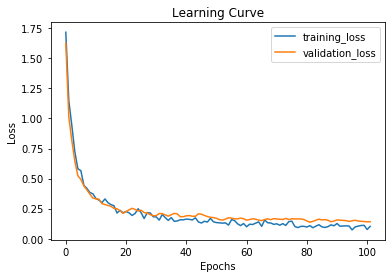

In [17]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()